In [2]:
%matplotlib widget

# Load and preprocess data
import torch
from torch import nn
import numpy as np

import os
import re

from prep_data import preprocess_data_3

import random

# A seed of 2023 is needed for good_initialization.model to work; but the seed needs to only be set here (not in the later cells)
seed = 2023
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

train_data, test_data = preprocess_data_3(17, 1, 16, 0.9)

In [4]:
seed = 2023
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

mode = "train_initial_weights"
# mode = "tune_existing_weights"

def cuda_get_device():
	is_cuda = torch.cuda.is_available()
	if is_cuda:
		return torch.device("cuda")
	else:
		print("GPU not available, CPU used")
		return torch.device("cpu")

device = cuda_get_device()

class GRUModel(nn.Module):
	def __init__(self, input_size, output_size, hidden_dim, n_layers, GRU_dropout):
		super(GRUModel, self).__init__()
		self.hidden_dim = hidden_dim
		self.n_layers = n_layers
		self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_dim, dropout=GRU_dropout)
		self.fc = nn.Linear(hidden_dim, output_size)
	
	def forward(self, x):
		hidden = self.gru(x)[0]
		hidden = hidden.contiguous().view(-1, self.hidden_dim)
		out = self.fc(hidden)
		return out

# Model Hyperparameters
hidden_state_size = 12
fc_layers = 1

model = GRUModel(input_size=64, output_size=1, hidden_dim=hidden_state_size, n_layers=fc_layers, GRU_dropout=0.3)

if mode == "train_initial_weights":
	n_epochs = 200
	lr = 0.01
else:
	n_epochs = 50
	lr=0.001
	model.load_state_dict(torch.load("C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\good_initialization.model"))

model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
milestones = [150, 300]
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.2)

# Training Run
loss_sequence = []
for epoch in range(1, n_epochs + 1):
	epoch_losses = torch.tensor([0],dtype=float).to(device)
	for data in train_data:
		optimizer.zero_grad()
		input_data = torch.from_numpy(data[0]).float().to(device)
		target_pred = torch.tensor(data[1]).unsqueeze(0).float().to(device)
		output = model(input_data)[-1]
		loss = criterion(output, target_pred)
		loss.backward()
		optimizer.step()
		epoch_losses += loss
	scheduler.step()
	loss_sequence.append(epoch_losses.to('cpu').item())
	if epoch%5 == 0:
		print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
		print("Loss: {:.4f}".format(epoch_losses.to('cpu').item()))

Epoch: 5/200............. Loss: 264.1086
Epoch: 10/200............. Loss: 175.8509
Epoch: 15/200............. Loss: 228.0255
Epoch: 20/200............. Loss: 163.9969
Epoch: 25/200............. Loss: 148.9148
Epoch: 30/200............. Loss: 138.7348
Epoch: 35/200............. Loss: 134.6779
Epoch: 40/200............. Loss: 125.4380
Epoch: 45/200............. Loss: 140.9482
Epoch: 50/200............. Loss: 155.0892
Epoch: 55/200............. Loss: 137.8921
Epoch: 60/200............. Loss: 134.6313
Epoch: 65/200............. Loss: 118.5562
Epoch: 70/200............. Loss: 109.9821
Epoch: 75/200............. Loss: 108.7206
Epoch: 80/200............. Loss: 111.8483
Epoch: 85/200............. Loss: 102.0521
Epoch: 90/200............. Loss: 93.0163
Epoch: 95/200............. Loss: 86.3152
Epoch: 100/200............. Loss: 95.3408
Epoch: 105/200............. Loss: 83.8607
Epoch: 110/200............. Loss: 81.3084
Epoch: 115/200............. Loss: 80.3780
Epoch: 120/200............. Loss: 83.

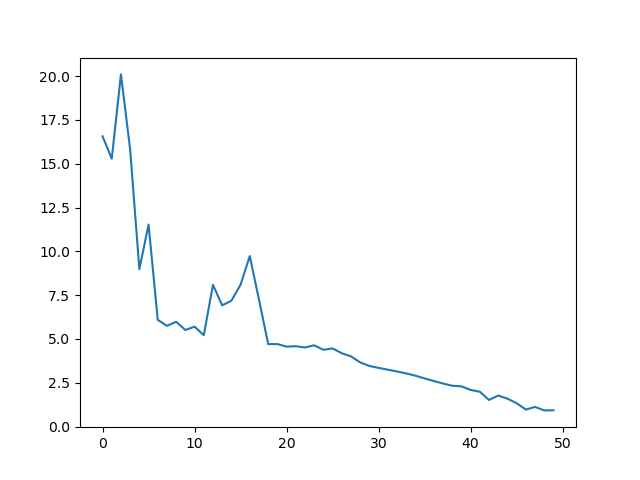

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_sequence)
plt.show()

In [34]:
torch.save(model.state_dict(),"C:\\Users\\jcarl\\Desktop\\ECEN 683\\Project Repo\\ECEN683-Blockage-Prediction\\saved_parameters\\good_initialization.model")

In [3]:
import matplotlib.pyplot as plt

predictions = []
targets = []
with torch.no_grad():
	for data in train_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(targets_numpy))
print(np.sum(pred))

1
290
291


In [4]:
# Evaluate on the test dataset
model.eval()

predictions = []
targets = []
with torch.no_grad():
	for data in test_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(pred))
print(np.sum(targets_numpy))

# print(np.where(test_targets != pred))
# print(np.where(np.abs(test_targets-pred) != 0))

0
33
33


In [5]:
# Test using a larger test dataset
from prep_data import get_all_outdoor_data

train_data, test_data = get_all_outdoor_data(1, 16, 0.9)

In [6]:
predictions = []
targets = []
with torch.no_grad():
	for data in test_data:
			input_data = torch.from_numpy(data[0]).float().to(device)
			target_pred = torch.tensor(data[1]).unsqueeze(0)
			output = torch.sigmoid(model(input_data)[-1])
			predictions.append(output.cpu().item())
			targets.append(target_pred.item())

pred = np.array(predictions)
pred = np.rint(pred).astype(int)
targets_numpy = np.array(targets)

print(np.sum(np.abs(targets_numpy-pred)))
print(np.sum(pred))
print(np.sum(targets_numpy))

[9.99999404e-01 1.58850249e-04 4.06346837e-04 1.95856919e-05
 9.99999404e-01 1.08241020e-05 2.77321419e-06 2.40440272e-06
 6.72880515e-06 9.99999404e-01 1.91766367e-06 9.99999404e-01
 9.99999285e-01 3.15205193e-06 9.99999404e-01 8.44746410e-06
 1.52428474e-05 2.02067822e-05 6.03552684e-02 1.99281499e-06
 7.11127541e-06 3.37445636e-05 2.46028849e-05 9.99999404e-01
 9.99999285e-01 9.99992609e-01 1.91806685e-05 9.99999404e-01
 9.99999404e-01 2.03662671e-06 9.99999404e-01 8.04135743e-06
 9.99999404e-01 3.14720790e-04 3.16967889e-05 2.17099841e-05
 1.65035885e-06 7.14916450e-06 9.99999404e-01 9.99999404e-01
 1.92440916e-06 9.99998927e-01 9.99999404e-01 7.23769335e-06
 9.99999404e-01 1.24818016e-05 7.73768261e-06 1.23724622e-05
 2.11579822e-06 9.99999404e-01 9.99999404e-01 1.59645933e-05
 9.99999404e-01 9.99999404e-01 9.99985218e-01 2.27077931e-06
 6.56534467e-05 9.99998689e-01 9.99999404e-01 9.99993324e-01
 9.99999404e-01 4.57099552e-04 6.49487629e-06 9.99999404e-01
 9.99999404e-01 2.067262